In [3]:
import matplotlib.pyplot as plt
import pandas as pd


from bold_dementia.cogpred import make_training_data, make_all_data
from bold_dementia.utils.configuration import get_config

from neuroginius.atlas import Atlas
from bold_dementia.cogpred import plot_matrix

config = get_config()
atlas = Atlas.from_name("schaefer200")
matrices, metadata = make_all_data(
    config["connectivity_matrices"],
    atlas.name,
    k=3,
    suffix="corr"
)
aal = atlas.from_name("aal")
aal.networks = list(map(lambda x: str(x).split("_")[0], aal.labels))

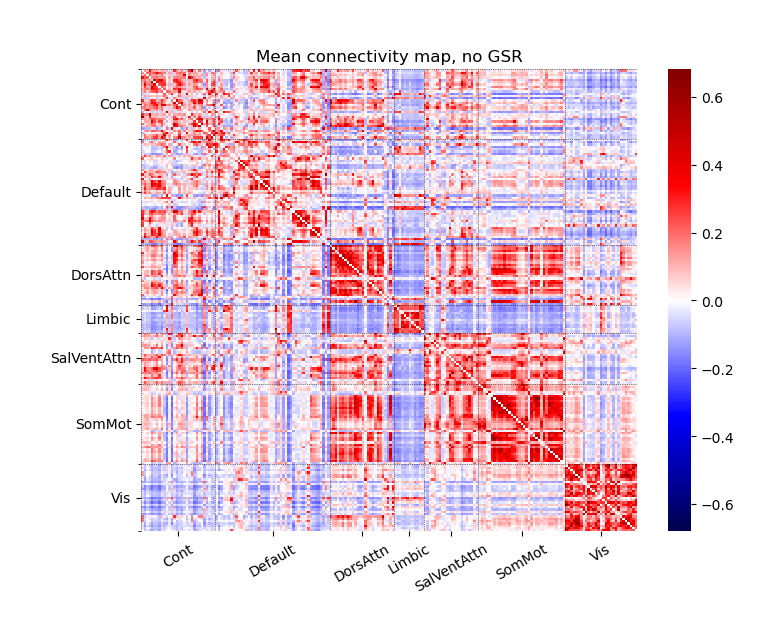

In [4]:
plot_matrix(matrices.mean(axis=0), atlas, cmap="seismic")
plt.title("Mean connectivity map, no GSR")
plt.show()

In [5]:
from neuroginius.networks import group_groupby

res = group_groupby(matrices, atlas)

In [44]:
from neuroginius.networks import group_by_networks
from neuroginius.atlas import Atlas
from neuroginius.iterables import unique
import itertools as it
import numpy as np

def default_agg_func(block):
    return (np.mean(block),)

# TODO replace singular by plural

class MatrixResult:
    def __init__(self, matrix, atlas) -> None:
        self.atlas = atlas
        if matrix.ndim == 2:
            matrix = matrix.reshape((1, *matrix.shape))
        self.matrix = matrix
        self._set_sorted_matrix()
    
    def _set_sorted_matrix(self):
        """Reorganize the matrix by macro labels, store
        the sorted matrix and a mapping from networks name
        to indexes in the sorted matrix
        """

        ticks, sort_index = group_by_networks(self.atlas.macro_labels)
        matrix_sort = np.ix_(sort_index, sort_index)

        self.sorted_matrix = self.matrix[:, *matrix_sort]
        new_labels = sorted(tuple(unique(self.atlas.macro_labels)))
        self.network_to_idx = pd.Series(dict(zip(
            new_labels,
            it.pairwise(ticks)
        )))

    def get_macro_matrix(self, agg_func=default_agg_func):
        """Get a matrix reorganized by networks

        Args:
            agg_func (function, optional): function to compute
            the aggregated of each cell, from the block of original
            values. Defaults to default_agg_func, which performs a simple
            mean

        Returns:
            DataFrame: summary per network of the original matrix.
        """
        gen = self._gen_macro_values(
            agg_func=agg_func
        )
        comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "connectivity"])
        pivoted = comparisons.pivot(index="node_a", columns="node_b")
        return pivoted.loc[:, "connectivity"]

    # This could be a function on its own
    def _gen_macro_values(self, agg_func):
        for network_a, network_b in it.product(self.network_to_idx.index, self.network_to_idx.index):
            loc_a, loc_b = self.network_to_idx[network_a], self.network_to_idx[network_b]
            self.block = self.matrix[:, loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]

            yield network_a, network_b, *agg_func(self.block)
    

In [45]:
mr = MatrixResult(matrices, atlas)

In [47]:
mr.get_macro_matrix()

node_b,Cont,Default,DorsAttn,Limbic,SalVentAttn,SomMot,Vis
node_a,,,,,,,
Cont,0.154687,0.022386,-0.010774,0.136401,0.114897,0.027243,-0.016383
Default,0.022386,0.076457,0.023684,-0.021396,0.032944,0.043493,0.022358
DorsAttn,-0.010774,0.023684,0.142297,-0.028537,-0.005758,-0.007210,0.079568
Limbic,0.136401,-0.021396,-0.028537,0.337006,0.049532,-0.011190,-0.048327
SalVentAttn,0.114897,0.032944,-0.005758,0.049532,0.200708,0.065831,0.014572
SomMot,0.027243,0.043493,-0.007210,-0.011190,0.065831,0.093746,0.038687
Vis,-0.016383,0.022358,0.079568,-0.048327,0.014572,0.038687,0.149251


<Axes: xlabel='node_b', ylabel='node_a'>

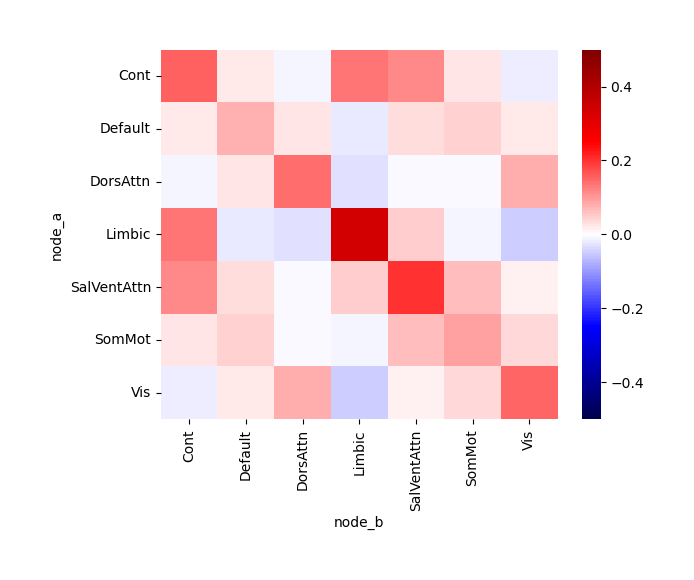

In [49]:
import seaborn as sns
sns.heatmap(mr.get_macro_matrix(), cmap="seismic", vmin=-0.5, vmax=0.5)